# Using a Simple RNN for forecasting

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def plot_series(time,series,format='-',start=0,end=None):
    plt.figure(figsize=(10,6))
    if type(series) is tuple:
        for series_num in series:
            plt.plot(time[start:end],series_num[start:end],format)
    else:
        plt.plot(time[start:end],series[start:end],format)
    plt.xlabel('time')
    plt.ylabel('value')
    plt.grid(True)
    plt.show()


def trend(time,slope=0):
    return time*slope

def seasonal_pattern(season_time):
    data_pattern=np.where(season_time<0.4,np.cos(season_time*2*np.pi),1/np.exp(3*season_time))
    return data_pattern

def seasonality(time,period,amplitude=1,phase=0):
    season_time=((time+phase)%period)/period
    data_pattern=amplitude*seasonal_pattern(season_time)
    return data_pattern

def noise(time,noise_level=1,seed=None):
    rnd=np.random.RandomState(seed)
    noise=rnd.randn(len(time))*noise_level
    return noise

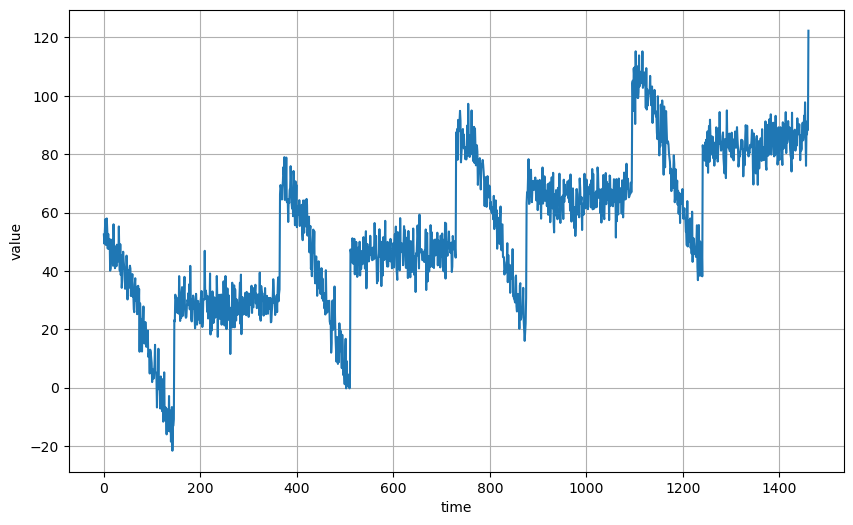

In [6]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

In [8]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [7]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

In [10]:
def windowed_dataset(series,window_size,batch_size,shuffle_buffer):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda window:window.batch(window_size+1))
    dataset=dataset.map(lambda window:(window[:-1],window[-1]))
    dataset=dataset.shuffle(shuffle_buffer)
    dataset=dataset.batch(batch_size).prefetch(1)
    return dataset

In [11]:
dataset=windowed_dataset(x_train,window_size,batch_size,shuffle_buffer_size)

In [13]:
for window in dataset.take(2):
    print(f'shape of feature: {window[0].shape}')
    print(f'shape of label: {window[1].shape}')

shape of feature: (32, 20)
shape of label: (32,)
shape of feature: (32, 20)
shape of label: (32,)


# build the model
- SimpleRNN layers expect a 3-dimensional tensor input with the shape [batch, timesteps, feature]
-  RNN simply routes its output back to the input. You will stack two of these layers in your model so the first one should have return_sequences set to True.

In [14]:
model_tune=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*100)
])

model_tune.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 20, 1)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 20, 40)            1680      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
 lambda_1 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 4,961
Trainable params: 4,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(
    lambda epochs: 1e-8*10**(epochs/20)
)
optimizer=tf.keras.optimizers.SGD(momentum=0.9)
model_tune.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer)
history=model_tune.fit(dataset,epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 4s 31ms/step - loss: 42.1053 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 1s 30ms/step - loss: 31.3594 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 1s 30ms/step - loss: 18.6079 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 1s 30ms/step - loss: 8.8902 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 1s 31ms/step - loss: 7.1862 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 1s 31ms/step - loss: 7.1256 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 1s 31ms/step - loss: 7.1049 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 1s 31ms/step - loss: 7.0519 - lr: 2.2387e-08
Epoch 9/100
31/31 [==============================] - 1s 32ms/step - loss: 7.0225 - lr: 2.5119e-08
Epoch 10/100
31/31 [==============================] - 1s 31ms/step - loss: 6.9890 - lr: 2.8184e-08
Epoch 11/100
31/

(1e-08, 0.001, 0.0, 50.0)

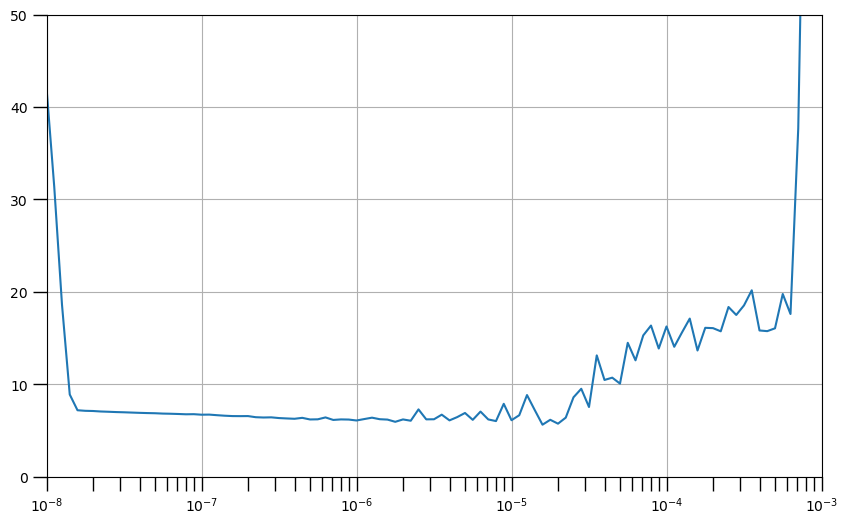

In [16]:
lrs=1e-8 *(10**(np.arange(100)/20))
plt.figure(figsize=(10,6))
plt.grid(True)
plt.semilogx(lrs,history.history['loss'])
plt.tick_params('both',length=10,width=1,which='both')
plt.axis([1e-8,1e-3,0,50])

(1e-07, 0.0001, 0.0, 20.0)

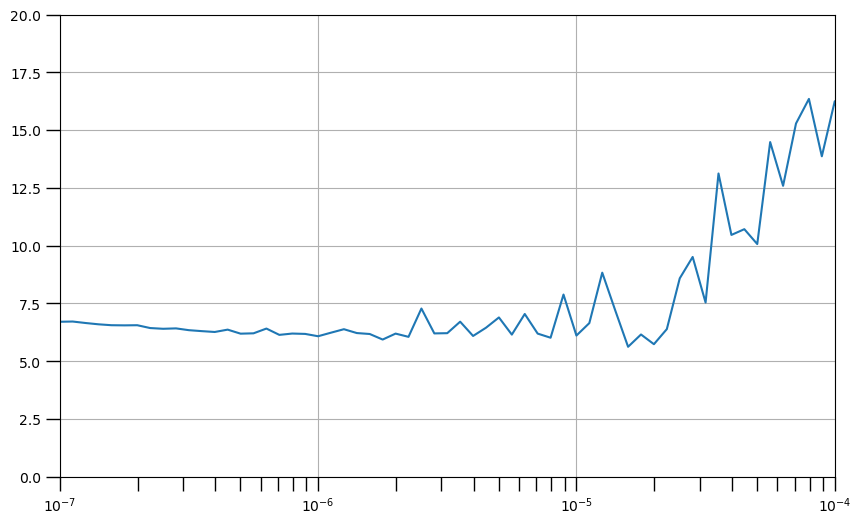

In [17]:
plt.figure(figsize=(10, 6))

# Set the grid
plt.grid(True)

# Plot the loss in log scale
plt.semilogx(lrs, history.history["loss"])

# Increase the tickmarks size
plt.tick_params('both', length=10, width=1, which='both')

# Set the plot boundaries
plt.axis([1e-7, 1e-4, 0, 20])


# train the model

In [18]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x:tf.expand_dims(x,axis=-1),input_shape=[window_size]),
    tf.keras.layers.SimpleRNN(40,return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x:x*100)
])
learning_rate=1e-6
optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate,momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),optimizer=optimizer,metrics=['mae'])
history=model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 38ms/step - loss: 37.8521 - mae: 38.3476
Epoch 2/100
31/31 [==============================] - 1s 37ms/step - loss: 16.7192 - mae: 17.2138
Epoch 3/100
31/31 [==============================] - 1s 32ms/step - loss: 14.7838 - mae: 15.2752
Epoch 4/100
31/31 [==============================] - 1s 36ms/step - loss: 13.4281 - mae: 13.9163
Epoch 5/100
31/31 [==============================] - 1s 44ms/step - loss: 12.5760 - mae: 13.0642
Epoch 6/100
31/31 [==============================] - 1s 37ms/step - loss: 11.8379 - mae: 12.3288
Epoch 7/100
31/31 [==============================] - 1s 31ms/step - loss: 11.1857 - mae: 11.6763
Epoch 8/100
31/31 [==============================] - 1s 32ms/step - loss: 10.4724 - mae: 10.9620
Epoch 9/100
31/31 [==============================] - 1s 30ms/step - loss: 9.7256 - mae: 10.2143
Epoch 10/100
31/31 [==============================] - 1s 34ms/step - loss: 9.0637 - mae: 9.5510
Epoch 11/100
31/31 [============

In [23]:
# model prediction
forecast=[]
forecast_series=series[split_time-window_size:]
for time in range(len(forecast_series)-window_size):
    forecast.append(model.predict(forecast_series[time:time+window_size][np.newaxis]))
results=np.array(forecast).squeeze()

1/1 [==============================] - 0s 23ms/step


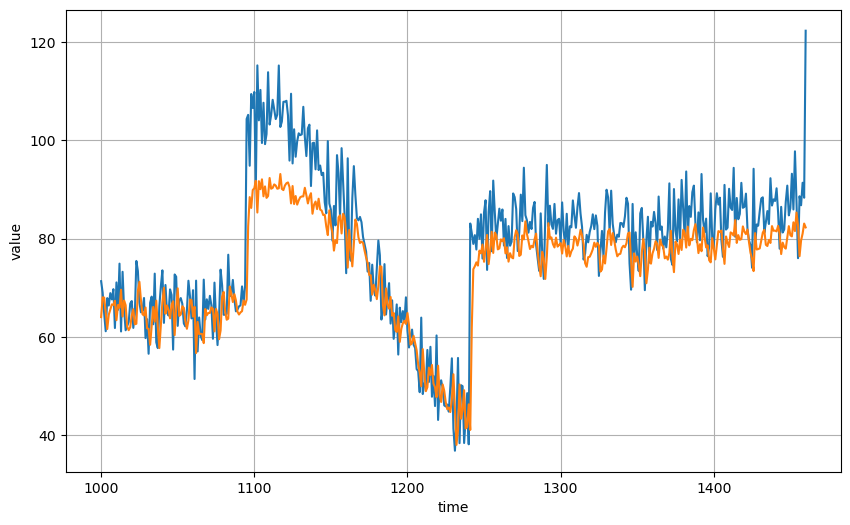

In [24]:
plot_series(time_valid,(x_valid,results))

In [28]:
# create batches for forecast
def model_forecast(model,series,window_size,batch_size):
    dataset=tf.data.Dataset.from_tensor_slices(series)
    dataset=dataset.window(window_size,shift=1,drop_remainder=True)
    dataset=dataset.flat_map(lambda w: w.batch(window_size))
    dataset=dataset.batch(batch_size).prefetch(1)
    forecast=model.predict(dataset)
    return forecast

15/15 [==============================] - 0s 11ms/step


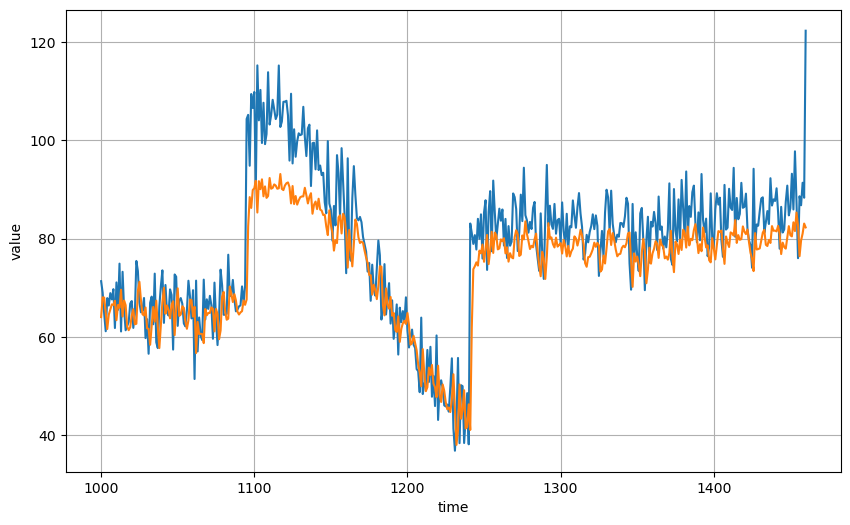

In [29]:
forecast_series=series[split_time-window_size:-1]
forecast=model_forecast(model,forecast_series,window_size,batch_size)
result=forecast.squeeze()
plot_series(time_valid,(x_valid,results))

In [30]:
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

77.7756
6.5985823
